In [1]:
import pandas as pd
from glob import glob
import os
import re
from matplotlib.pyplot import *
import pysam
from collections import Counter, defaultdict
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [84]:
#count_fns = os.listdir('counts')
count_fns = glob('counts/ml*_[HPC]_*.txt')
names = [re.sub(r".*([HPC]_\d\d\d\d).*",r"\1",fn) for fn in count_fns]
hd = [n for n in names if n.startswith('H')]
control = [n for n in names if n.startswith('C')]
pds = [n for n in names if n.startswith('P')]
cnts = [pd.read_table(fn,index_col=0,header=None) for fn in count_fns]

In [85]:
all_counts = pd.concat(cnts,join="inner",axis=1)
all_counts.columns = names
names.sort()
all_counts = all_counts[names]

#all_counts = all_counts.ix[all_counts.index,:]
#all_counts.index = ['exon_%02d'%(int(i.replace('exon_',''))) for i in all_counts.index]

# put samples in rows
all_counts = all_counts.T

# DESeq2 size factors are in this data frame
size_factors = pd.read_csv("../HD_PD_diffexp/all_mRNA_nonzero_norm_counts_sizeFactors.csv",
                           index_col=0,
                           names=("factor",))
size_factors = size_factors.ix[all_counts.index,:]
# DESeq2 divides its counts by sizeFactors to normalize
all_counts = all_counts.divide(size_factors.factor,axis='index')

In [71]:
htt = pd.read_table('HTT.gff',header=None,names=('chr','src','type','start','end','name','strand','score','attr'))
htt.index = ["exon_%02d"%_ for _ in htt.index]

introns = []
for i, (i_st, i_en, attr) in enumerate(zip(htt.end[:-1],htt.start[1:],htt.attr[:-1])) :
    introns.append(['chr4','HAVANA','intron',i_st,i_en,'.','+','.',attr.replace('exon','intron')])
introns = pd.DataFrame(introns,columns=htt.columns)
introns.index = ["intron_%02d"%_ for _ in introns.index]
htt_all = pd.concat([htt,introns]).sort('start')

htt_all['width'] = 1.*htt_all.end - htt_all.start
htt_all['name'] = htt_all.index

htt_all[htt_all.columns[:-1]].to_csv('HTT_full.gff',sep='\t',index=False,header=False)
htt_all.head()
htt = htt_all
exon_i = [i for i in htt.index if i.startswith('exon')]
intron_i = [i for i in htt.index if i.startswith('intron')]

Index(['exon_00', 'intron_00', 'exon_01', 'intron_01', 'exon_02', 'intron_02',
       'exon_03', 'intron_03', 'exon_04', 'intron_04', 
       ...
       'intron_61', 'exon_62', 'intron_62', 'exon_63', 'intron_63', 'exon_64',
       'intron_64', 'exon_65', 'intron_65', 'exon_66'],
      dtype='object', name=0, length=133)

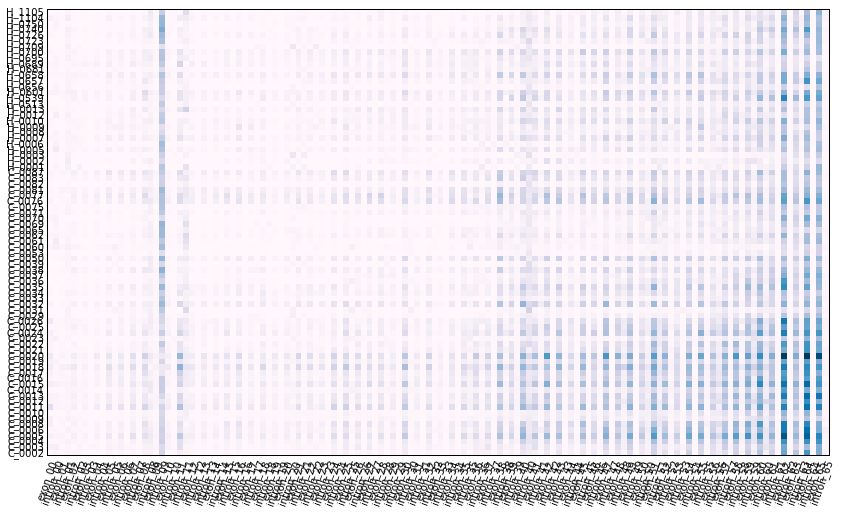

In [73]:
figure(figsize=(14,8))
pcolor(all_counts[all_counts.columns[0:-1]],cmap=get_cmap('PuBu'))
xticks(range(all_counts.shape[1]),all_counts.columns[0:-1],rotation=70)
yticks(arange(len(names))+0.5,names)
axis('tight')
tick_params(which='both',bottom=None,top=None,left=None,right=None)
None
all_counts.columns

/usr3/graduate/labadorf/software/mypython/3.4.3/lib/python3.4/site-packages/pandas/tools/plotting.py:2633: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  warnings.warn(msg, FutureWarning)


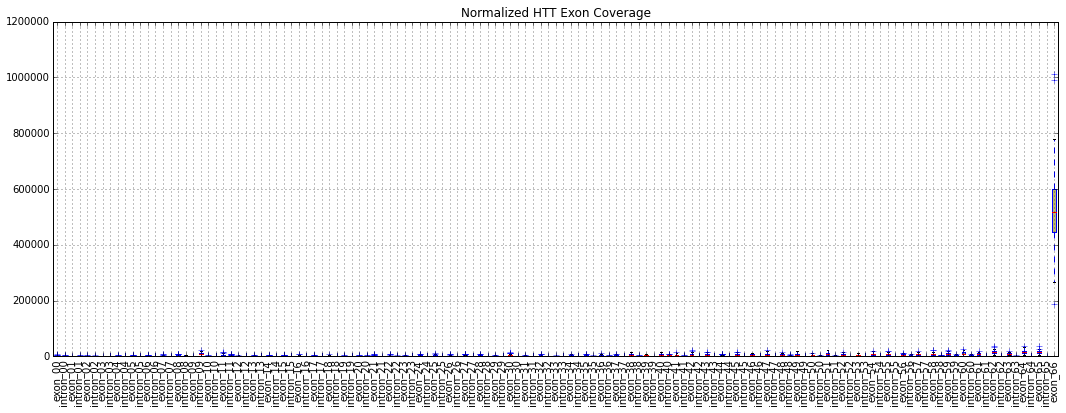

In [91]:
from matplotlib.patches import Polygon
figure(figsize=(18,6))
bp = all_counts[all_counts.columns].boxplot(rot=90)
title("Normalized HTT Exon Coverage")

# color the boxes based on whether they're exons or introns
numBoxes = len(all_counts.columns)
boxColors = ['darkkhaki','royalblue']
ax1 = gca()
for i,box in enumerate(bp['boxes']):
  boxX = []
  boxY = []
  for j in range(5):
      boxX.append(box.get_xdata()[j])
      boxY.append(box.get_ydata()[j])
  boxCoords = zip(boxX,boxY)
  # Alternate between Dark Khaki and Royal Blue
  k = i % 2
  boxPolygon = Polygon(list(boxCoords), facecolor=boxColors[k])
  ax1.add_patch(boxPolygon)
#all_counts.ix[hd,0:-1].boxplot(rot=70)
#all_counts.ix[control,0:-1].boxplot(rot=70)
None

/usr3/graduate/labadorf/software/mypython/3.4.3/lib/python3.4/site-packages/pandas/tools/plotting.py:2633: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  warnings.warn(msg, FutureWarning)


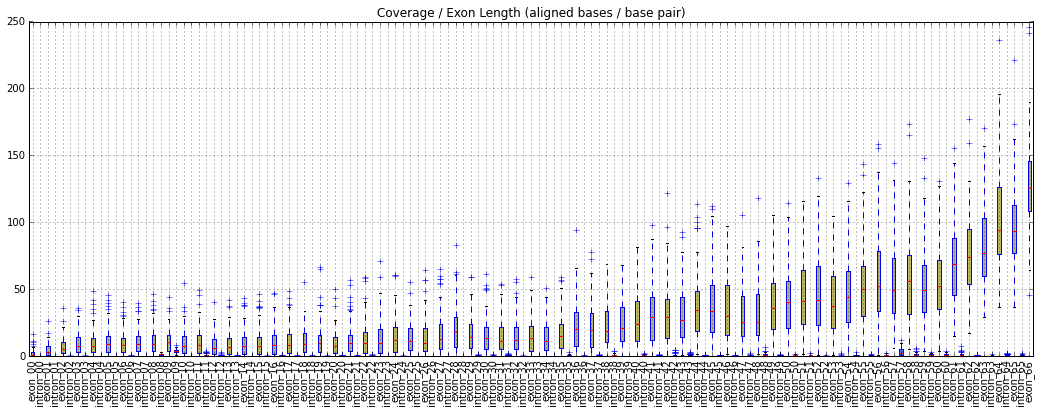

In [92]:
figure(figsize=(18,6))
fpbp = all_counts.divide(htt.width,axis="columns")
#fpbp['class'] = [s[0] for s in fpbp.index]
bp = fpbp.boxplot(rot=90)
title("Coverage / Exon Length (aligned bases / base pair)")

# color the boxes based on whether they're exons or introns
numBoxes = len(all_counts.columns)
boxColors = ['darkkhaki','royalblue']
ax1 = gca()
for i,box in enumerate(bp['boxes']):
  boxX = []
  boxY = []
  for j in range(5):
      boxX.append(box.get_xdata()[j])
      boxY.append(box.get_ydata()[j])
  boxCoords = list(zip(boxX,boxY))
  # Alternate between Dark Khaki and Royal Blue
  k = i % 2
  boxPolygon = Polygon(boxCoords, facecolor=boxColors[k])
  ax1.add_patch(boxPolygon)
None

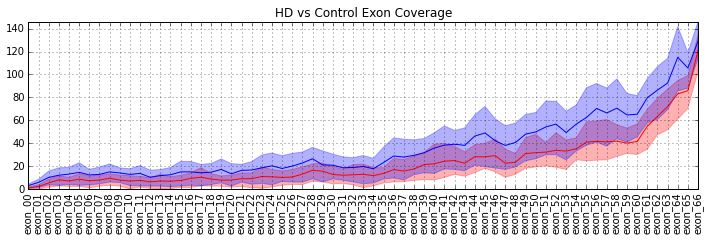

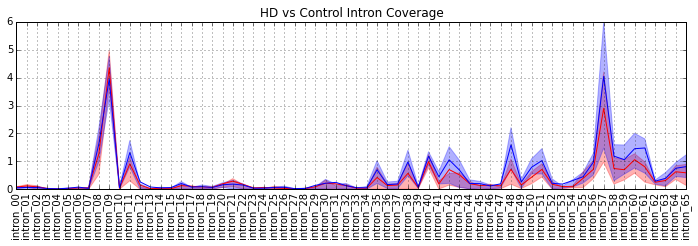

In [93]:
def coverage_plot(col_set) :
    figure(figsize=(12,3))
    
    xt = arange(len(col_set))
    #xt = htt.start[col_set]
    #xt = cumsum(htt.width[col_set])
    
    hd_up_quant, hd_low_quant = list(zip(*[(i[1].quantile(0.75),i[1].quantile(0.25)) for i in fpbp.ix[hd,col_set].iteritems()]))
    fill_between(xt,hd_up_quant,hd_low_quant,color='r',alpha=0.3)

    control_up_quant, control_low_quant = list(zip(*[(i[1].quantile(0.75),i[1].quantile(0.25)) for i in fpbp.ix[control,col_set].iteritems()]))
    fill_between(xt,control_up_quant,control_low_quant,color='b',alpha=0.3)

    hd_mean = fpbp.ix[hd,col_set].mean(axis=0)
    control_mean = fpbp.ix[control,col_set].mean(axis=0)

    plot(xt,hd_mean,'r-')
    plot(xt,control_mean,'b-')
    axis("tight")
    xticks(list(xt),col_set,rotation=90)
    grid()

    None

coverage_plot(exon_i)    
title('HD vs Control Exon Coverage')
savefig('exon_coverage.svg')

coverage_plot(intron_i)    
title('HD vs Control Intron Coverage')
savefig('intron_coverage.svg')

hd_mean = fpbp.ix[hd,].mean(axis=0)
pd_mean = fpbp.ix[pds,].mean(axis=0)
control_mean = fpbp.ix[control,].mean(axis=0)

hd_mean_norm = hd_mean.divide(hd_mean+pd_mean+control_mean).fillna(0)
pd_mean_norm = pd_mean.divide(hd_mean+pd_mean+control_mean).fillna(0)
control_mean_norm = control_mean.divide(hd_mean+pd_mean+control_mean).fillna(0)

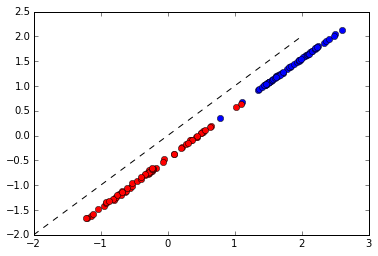

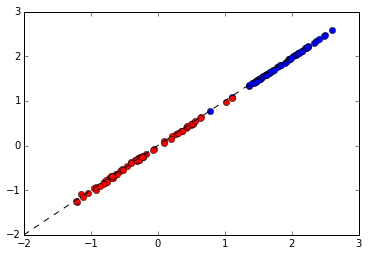

In [97]:
cnt_fns = glob("counts/[HPC]_*merged*_HTT_exon_counts.txt")
cpbp = pd.DataFrame(index=htt.index,columns=tuple('HPC'))
for fn in cnt_fns :
    ds_cnts = pd.read_table(fn,index_col=0,names=('reads',))
    ds_cpbp = ds_cnts.divide(htt.width,axis=0)
    cpbp[fn.replace('counts/','')[0]] = ds_cpbp

# I found the number of samples manually
cpbp['H'] /= 28
cpbp['P'] /= 29
cpbp['C'] /= 50

all_cpbp = pd.read_table('counts/all_merged_HTT_exon_counts.txt',index_col=0,names=('reads',))
all_cpbp = all_cpbp.divide(htt.width,axis=0)
all_cpbp /= 107

sum_cpbp = pd.DataFrame(index=htt.index,columns=tuple('HPC'))
sum_cpbp['H'] = fpbp.ix[hd,].mean(axis=0)
sum_cpbp['P'] = fpbp.ix[pds,].mean(axis=0)
sum_cpbp['C'] = fpbp.ix[control,].mean(axis=0)

# sanity checks
# sum of conditions mean counts should be ~ concatenated counts
plot(log10(cpbp.ix[exon_i].sum(axis=1)),log10(all_cpbp.ix[exon_i]),'bo')
plot(log10(cpbp.ix[intron_i].sum(axis=1)),log10(all_cpbp.ix[intron_i]),'ro')
plot([-2,2],[-2,2],'k--')

# mean of individual normalized counts should be very similar to concatenated counts
figure()
plot(log10(cpbp.ix[exon_i].sum(axis=1)),log10(sum_cpbp.ix[exon_i].sum(axis=1)),'bo')
plot(log10(cpbp.ix[intron_i].sum(axis=1)),log10(sum_cpbp.ix[intron_i].sum(axis=1)),'ro')
plot([-2,2],[-2,2],'k--')

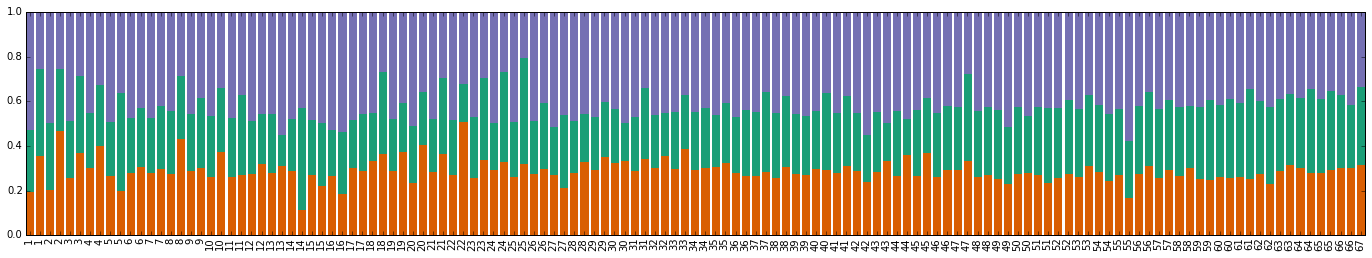

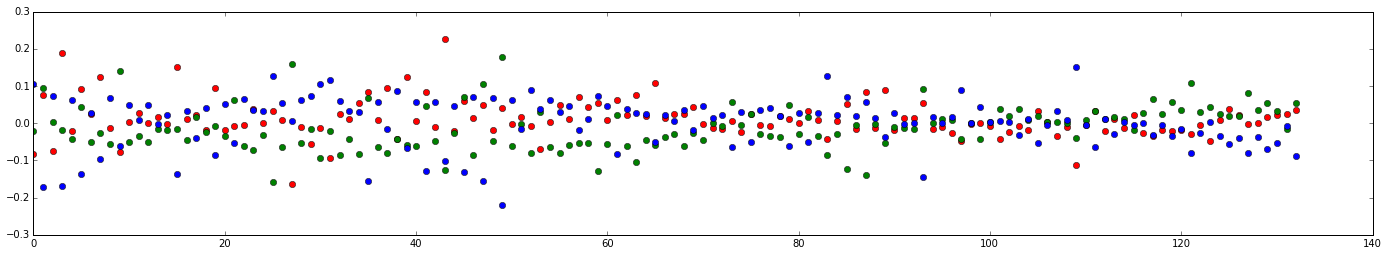

In [119]:
# 1-way anova using individual normalized counts
from scipy import stats
import statsmodels.stats.multitest as smm

anova_pvals = pd.DataFrame(index=htt.index,columns=('f','p'))
for i in htt.index :   
    f_val, p_val = stats.f_oneway(fpbp.ix[hd,i], fpbp.ix[control,i])
    anova_pvals.ix[i] = (f_val,p_val)

rej,padj = smm.multipletests(anova_pvals.p, alpha=0.05, method='b')[:2]
anova_pvals['padj'] = padj

norm_sum_cpbp = sum_cpbp.divide(sum_cpbp.sum(axis=1),axis=0)
norm_sum_cpbp
f = figure(figsize=(24,4))
bar_chart(norm_sum_cpbp,f.gca())
overall_props = sum_cpbp.sum()/sum_cpbp.sum().sum()
prop_diff = norm_sum_cpbp.subtract(overall_props,axis=1)
figure(figsize=(24,4))
plot(prop_diff['H'],'ro')
plot(prop_diff['P'],'go')
plot(prop_diff['C'],'bo')

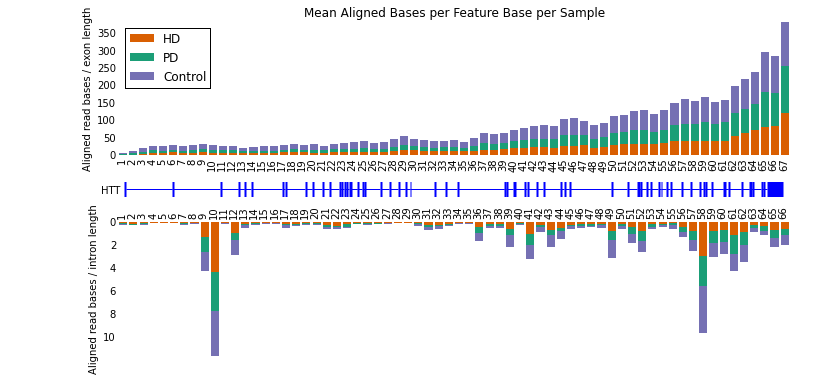

In [96]:
cd = {"P":"#1b9e77",
      "H": "#d95f02",
      "C": "#7570b3"}

cpbp = sum_cpbp

def bar_chart(cpbp_feat,ax=None) :
    #bar_labels = lambda x: ['%s %d'%(_.split('_')[0],int(_.split('_')[1])+1) for _ in x]
    bar_labels = lambda x: [int(_.split('_')[1])+1 for _ in x]

    x = range(cpbp_feat.shape[0])
    ax = figure(figsize=(12,4)).gca() if ax is None else ax
    ax.bar(x,cpbp_feat['H'],color=cd['H'],edgecolor='none',label='HD')
    ax.bar(x,cpbp_feat['P'],bottom=cpbp_feat['H'],color=cd['P'],edgecolor='none',label='PD')
    ax.bar(x,cpbp_feat['C'],bottom=cpbp_feat[['P','H']].sum(axis=1),color=cd['C'],edgecolor='none',label='Control')
    ax.axis('tight')
    
    ax.set_xticks(arange(cpbp_feat.shape[0])+0.375)
    ax.set_xticklabels(bar_labels(cpbp_feat.index),rotation=90)
    #legend(loc='upper left')

    return ax

(sub_f,(exon_ax,intron_ax)) = subplots(2,1,figsize=(12,6))

subplots_adjust(hspace=0.5)
exon_ax = bar_chart(cpbp.ix[exon_i],exon_ax)
exon_ax.set_title('Mean Aligned Bases per Feature Base per Sample')
#exon_ax.set_xlabel('exon')
exon_ax.legend(loc='upper left')
exon_ax.xaxis.set_tick_params(size=0)
exon_ax.yaxis.set_tick_params(size=0)
exon_ax.set_frame_on(False)
exon_ax.set_ylabel('Aligned read bases / exon length')

intron_ax.xaxis.set_tick_params(labeltop='on',labelbottom='off')
intron_ax = bar_chart(-cpbp.ix[intron_i],intron_ax)
intron_ax.xaxis.set_tick_params(size=0)
intron_ax.yaxis.set_tick_params(size=0)
intron_ax.set_frame_on(False)
intron_ax.set_ylabel('Aligned read bases / intron length')
intron_ax.set_yticklabels([int(_) for _ in abs(intron_ax.get_yticks())])

# draw the gene model
model_ax = sub_f.add_axes([0.02,0.46,0.9,0.1])
model_ax.set_axis_off()
max_cnt = max(read_cnts)
model_y = log10(max_cnt)*1.15
margin = (htt_region[1]-htt_region[0])*.045
model_x = htt_region[0]+margin, htt_region[1]-margin
sc = scale([htt.start.min(),htt.end.max()],model_x)
min_w = (htt_region[1]-htt_region[0])*0.003
model_ax.text(htt_region[0]-margin*.75,model_y-0.05,"HTT")
for segment in htt.itertuples() :
    i,chrm,src,typ,st,en,name,strand,_1,attr,w = segment
    lw = 15 if i.startswith('exon') else 1
    en = en if (en-st) > min_w else st+min_w
    model_ax.plot((st,en),(model_y,)*2,'b-',linewidth=lw,solid_capstyle='butt',alpha=1)

sub_f.savefig('figure_1b.svg');

In [4]:
reads = pysam.AlignmentFile("HTT_alignments/all_merged_HTT.bam",mode='rb')
htt_counts = Counter()
htt_region = (htt.start.min()-100, htt.end.max()+100)
for r in reads :
    for rp,gp in r.get_aligned_pairs(matches_only=True) :
        if htt_region[0] <= gp < htt_region[1] :
            htt_counts[gp] += 1

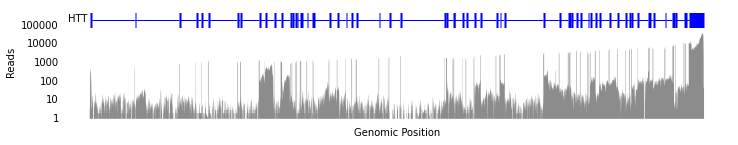

In [392]:
f = figure(figsize=(12,2))
gca().set_frame_on(False)
gca().xaxis.set_tick_params(size=0)
gca().yaxis.set_tick_params(size=0)
gca().set_xticklabels([])
gp = sorted(list(htt_counts.keys()))
read_cnts = [htt_counts[_] for _ in gp]
fill_between(gp,[0]*len(read_cnts),log10(read_cnts),color='gray',alpha=0.9,edgecolor="none")

# draw the gene model
max_cnt = max(read_cnts)
model_y = log10(max_cnt)*1.15
margin = (htt_region[1]-htt_region[0])*.045
model_x = htt_region[0]+margin, htt_region[1]-margin
sc = scale([htt.start.min(),htt.end.max()],model_x)
min_w = (htt_region[1]-htt_region[0])*0.003
text(htt_region[0]-margin*.75,model_y-0.1,"HTT")
for segment in htt.itertuples() :
    i,chrm,src,typ,st,en,name,strand,_1,attr,w = segment
    lw = 15 if i.startswith('exon') else 1
    en = en if (en-st) > min_w else st+min_w
    plot((st,en),(model_y,)*2,'b-',linewidth=lw,solid_capstyle='butt',alpha=1)

axis((htt_region[0]-margin,htt_region[1]+margin,0,log10(max_cnt)*1.3))
yt = range(max(int(_) for _ in yticks()[0]))
yticks(yt,[10**_ for _ in yt[:-1]]+[''])
ylabel('Reads')
xlabel('Genomic Position')
savefig('figure_1a.svg');

In [5]:
intron_bed = pd.read_table("HTT_alignments/all_merged_HTT.bed",names=('chr','st','en','name','reads'))
splice_reads = pysam.AlignmentFile("HTT_alignments/all_merged_HTT_reads.bam",mode='rb')

# these are custom defined using IGV
splice_regions = ["chr4:3,122,657-3,125,708",
                  "chr4:3,127,546-3,129,987",
                  "chr4:3,129,985-3,130,317",
                  "chr4:3,147,882-3,160,569",
                  "chr4:3,172,847-3,174,849",
                  "chr4:3,180,442-3,182,514",
                  "chr4:3,188,868-3,204,258",
                  "chr4:3,206,723-3,209,011",
                  "chr4:3,212,528-3,215,247",
                  "chr4:3,217,696-3,220,357",
                  "chr4:3,238,365-3,240,139"]
splice_regions = list(map(lambda _: (_.split(":")[0],)+tuple(map(int,_.split(":")[1].replace(',','').split('-'))),splice_regions))
region_counts = defaultdict(dict)
for region in splice_regions :
    region_introns_idx = ((intron_bed.st > region[1]) & (intron_bed.en < region[2]) & (intron_bed.reads >= 10))
    region_introns = intron_bed[region_introns_idx]
    
    region_counts[region]['introns'] = region_introns

    reg_reads = reads.fetch(*region)
    region_counts[region]['read_counts'] = Counter()
    for r in reg_reads :
        for rp,gp in r.get_aligned_pairs(matches_only=True) :
            if region[1] <= gp < region[2] :
                region_counts[region]['read_counts'][gp] += 1
                
    reg_reads = splice_reads.fetch(*region)
    region_counts[region]['splice_counts'] = Counter()
    for r in reg_reads :
        for rp,gp in r.get_aligned_pairs(matches_only=True) :
            if region[1] <= gp < region[2] :
                region_counts[region]['splice_counts'][gp] += 1

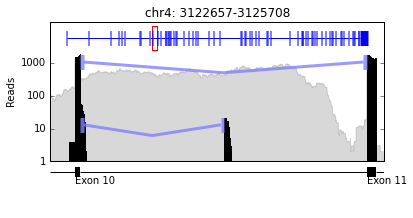

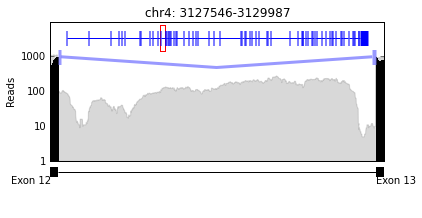

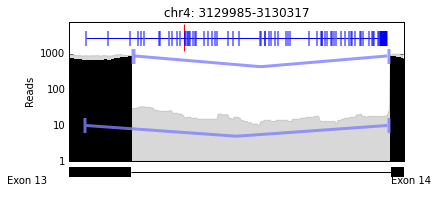

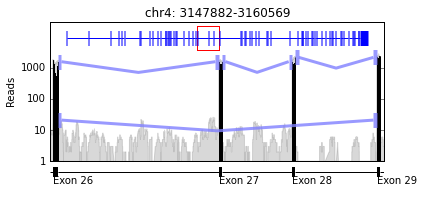

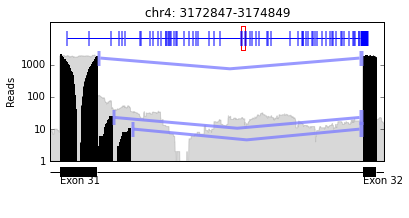

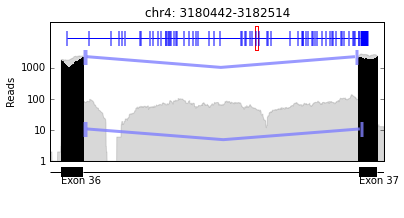

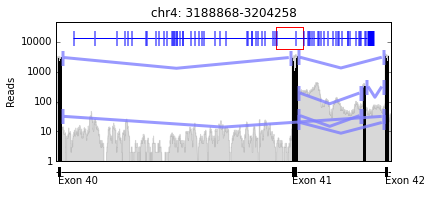

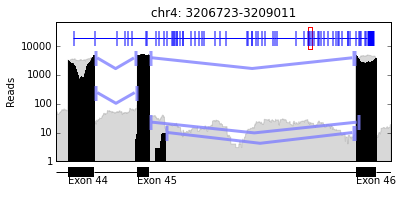

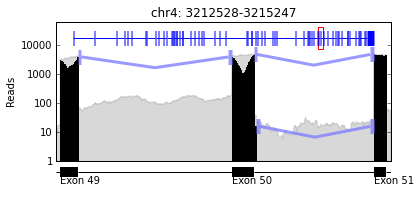

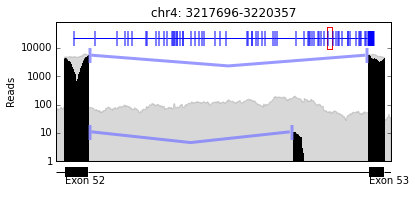

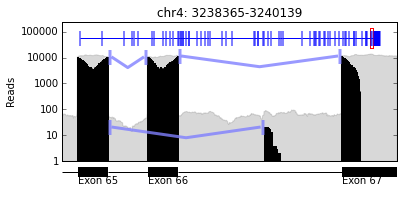

In [67]:
from matplotlib.patches import Rectangle
def scale(src,dest=(0,1)) :
    def sc(x) :
        frac_x = (x-src[0])/(src[1]-src[0])
        return dest[0]+(dest[1]-dest[0])*frac_x
    return sc

inc_labels = lambda x: ['%s_%02d'%(_.split('_')[0],int(_.split('_')[1])+1) for _ in x]
for r in splice_regions :
    cnts_d = region_counts[r]
    f = figure(figsize=(6,2.5))
    main_ax = f.gca()
    
    main_ax.xaxis.set_tick_params(size=0)
    main_ax.set_xticklabels([])
    
    gp = sorted(list(cnts_d['read_counts'].keys()))
    read_cnts = [cnts_d['read_counts'][_] for _ in gp]
    fill_between(gp,[0]*len(read_cnts),log10(read_cnts),color='gray',alpha=0.3)
    
    gp = sorted(list(cnts_d['splice_counts'].keys()))
    splice_cnts = [cnts_d['splice_counts'][_] for _ in gp]
    main_ax.bar(gp,log10(splice_cnts),color='black')

    # draw the gene model
    max_cnt = max(splice_cnts+read_cnts)
    model_y = log10(max_cnt)*1.15
    margin = (r[2]-r[1])*.05
    model_x = r[1]+margin, r[2]-margin
    sc = scale([htt.start.min(),htt.end.max()],model_x)
    min_w = (r[2]-r[1])*0.003
    #text(r[1]+margin*.25,model_y-0.04,"HTT")
    for segment in htt.itertuples() :
        i,chrm,src,typ,st,en,name,strand,_1,attr,w = segment
        lw = 15 if i.startswith('exon') else 1
        st,en = sc(st), sc(en)
        en = en if (en-st) > min_w else st+min_w
        main_ax.plot((st,en),(model_y,)*2,'b-',linewidth=lw,solid_capstyle='butt',alpha=1)
        #if i.startswith('exon') :
        #    txt = int(i[-2:])+1
        #    text(st,model_y-0.3,txt)

    # draw the red box indicating current location
    h=0.75
    rect = Rectangle((sc(r[1]),model_y-h/2),width=sc(r[2])-sc(r[1]),height=h,facecolor="none",edgecolor="red")
    main_ax.add_patch(rect)
 
    # draw the introns
    for i,chrm,st,en,name,cnt in cnts_d['introns'].itertuples() :
        #plot([st,en],[log10(cnt)]*2,'-',color=(0.5,0.5,1),linewidth=5,solid_capstyle='butt',alpha=0.8)
        main_ax.plot([st+(r[2]-r[1])*0.01,st+(en-st)/2,en-(r[2]-r[1])*0.01],[log10(cnt),log10(cnt)-log10(max_cnt)*0.1,log10(cnt)],
            color=(0.5,0.5,1),linewidth=3,solid_capstyle='butt',alpha=0.8)
        main_ax.plot([st,st+(r[2]-r[1])*0.01],[log10(cnt),log10(cnt)],
            color=(0.5,0.5,1),linewidth=15,solid_capstyle='butt',alpha=0.8)
        main_ax.plot([en-(r[2]-r[1])*0.01,en],[log10(cnt),log10(cnt)],
            color=(0.5,0.5,1),linewidth=15,solid_capstyle='butt',alpha=0.8)
    
    main_ax.axis([r[1],r[2],0,log10(max_cnt)*1.3])
    main_ax.set_title("%s: %d-%d"%r)
    
    yt = range(max(int(_) for _ in yticks()[0]))
    main_ax.set_yticks(yt)
    main_ax.set_yticklabels([10**_ for _ in yt])
    
    main_ax.set_ylabel('Reads')
    
    htt_features = htt[((htt.end>r[1]) & (htt.start<r[2]))]
    
    # draw the local gene model below the main axis
    model_ax = f.add_axes([0.125,0,0.775,0.11])
    model_ax.axis([r[1],r[2],0,2])
    model_ax.set_axis_off()
    for i,chrm,src,type,st,en,name,strand,score,attr,width in htt_features.itertuples() :
        lw = 10 if i.startswith('exon') else 1
        model_ax.plot([max(st,r[1]),min(en,r[2])],[1.2,1.2],'k-',lw=lw,solid_capstyle='butt')
        if i.startswith('exon') :
            label = i.split('_')[0].capitalize()+" "+str(int(i.split('_')[1])+1)
            model_ax.text(st,0,label)
    
    svg_fn = "%s_%d_%d_"%r+'_'.join(inc_labels(htt_features.index))+'_AS.svg'
    f.savefig(svg_fn)

In [39]:
model_ax.get_position()

Bbox('array([[ 0.125,  0.   ],\n       [ 0.875,  0.1  ]])')

In [9]:
htt.ix[intron_i][htt.width<300]

/usr3/graduate/labadorf/software/mypython/3.4.3/lib/python3.4/site-packages/pandas/core/frame.py:1819: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


,chr,src,type,start,end,name,strand,score,attr,width
intron_12,chr4,HAVANA,intron,3130047,3130305,intron_12,+,.,ID=intron:ENST00000355072.7:13;Parent=ENST0000...,258
intron_14,chr4,HAVANA,intron,3131397,3131638,intron_14,+,.,ID=intron:ENST00000355072.7:15;Parent=ENST0000...,241
intron_16,chr4,HAVANA,intron,3132720,3132814,intron_16,+,.,ID=intron:ENST00000355072.7:17;Parent=ENST0000...,94
intron_19,chr4,HAVANA,intron,3135967,3136226,intron_19,+,.,ID=intron:ENST00000355072.7:20;Parent=ENST0000...,259
intron_31,chr4,HAVANA,intron,3174799,3174946,intron_31,+,.,ID=intron:ENST00000355072.7:32;Parent=ENST0000...,147
intron_42,chr4,HAVANA,intron,3206675,3206807,intron_42,+,.,ID=intron:ENST00000355072.7:43;Parent=ENST0000...,132
intron_43,chr4,HAVANA,intron,3206983,3207281,intron_43,+,.,ID=intron:ENST00000355072.7:44;Parent=ENST0000...,298
intron_57,chr4,HAVANA,intron,3228745,3228880,intron_57,+,.,ID=intron:ENST00000355072.7:58;Parent=ENST0000...,135
intron_61,chr4,HAVANA,intron,3235398,3235565,intron_61,+,.,ID=intron:ENST00000355072.7:62;Parent=ENST0000...,167
intron_64,chr4,HAVANA,intron,3238609,3238818,intron_64,+,.,ID=intron:ENST00000355072.7:65;Parent=ENST0000...,209


# Old stuff

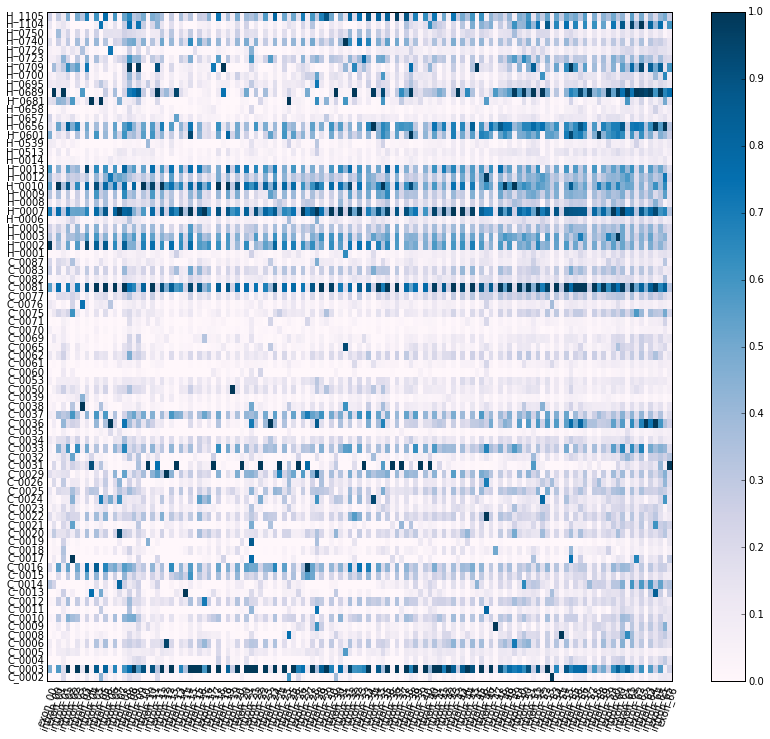

In [141]:
figure(figsize=(14,12))
norm_fpbp = fpbp/fpbp.max(axis=0)
norm_fpbp = norm_fpbp.fillna(0)
norm_fpbp[isinf(norm_fpbp)] = 0
pcolor(norm_fpbp,cmap=get_cmap('PuBu'))
xticks(range(all_counts.shape[1]),all_counts.columns,rotation=70)
yticks(arange(len(names))+0.5,names)
axis('tight')
colorbar()
tick_params(which='both',bottom=None,top=None,left=None,right=None)
None

In [ ]:
from glob import glob
bed_fns = glob('Coordinates_hg19_SV/*.bed')
sv_names = []

beds = [pd.read_table(fn,skiprows=2,header=None,names=('chr','start','end','name','score')) for fn in bed_fns]
for fn, bed in zip(bed_fns,beds) :
    bed.sv_name = re.sub(r'^Coordinates_hg19_SV/(.*)\.bed$',r'\1',fn)
    sv_names.append(bed.sv_name)
    bed.index = ['exon_%02d'%int(n.replace('Exon_','').replace('_truncation','')) for n in bed.name]
    
sv_names.sort(key=lambda x: int(x.replace('SV','')))
isoforms = pd.DataFrame(index=sv_names,columns=htt.index)
isoforms = isoforms.fillna(0)

for bed in beds :
    isoforms.ix[bed.sv_name,bed.index] = 3
c = get_cmap('PuBu')
c(256)

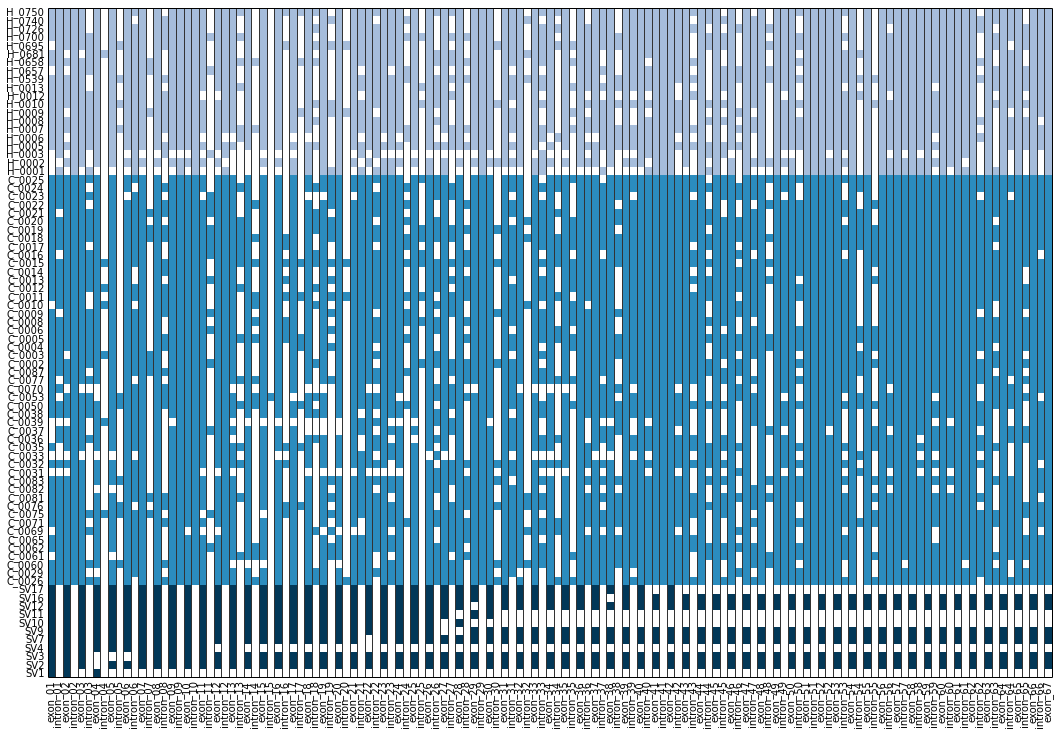

In [112]:
from matplotlib.colors import ListedColormap

bin_cm = ListedColormap(('#ffffff','#a6bddb','#2b8cbe',c(256)),(0,1,2,3))

figure(figsize=(18,12))
fpbp_bin_hd = (fpbp.ix[hd,:]!=0).astype('int')
fpbp_bin_control = (fpbp.ix[control,:]!=0).astype('int')
fpbp_bin_control[fpbp_bin_control==1] = 2
pcol_df = pd.concat([isoforms,fpbp_bin_control,fpbp_bin_hd])
pcolor(pcol_df,cmap=bin_cm)
xticks(arange(len(isoforms.columns))+0.5,isoforms.columns,rotation=90)
yticks(arange(len(isoforms.index)+len(fpbp.index))+0.5,isoforms.index.tolist()+control+hd)
axis('tight')
[vlines(i,0,pcol_df.shape[0],'#333333') for i in range(1,pcol_df.shape[1])]
tick_params(which='both',bottom=None,top=None,left=None,right=None)
None

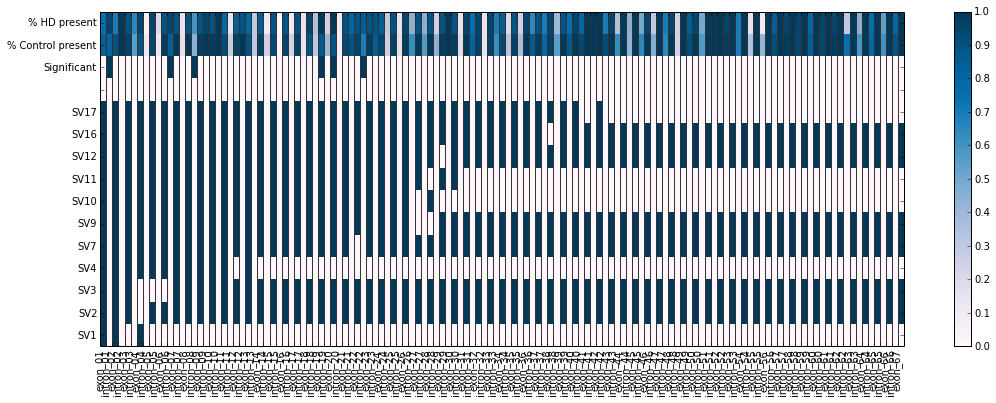

In [105]:
fpbp_bin_hd = (fpbp.ix[hd,]!=0).astype('int')
hd_missing = fpbp_bin_hd.mean(axis=0)

fpbp_bin_control = (fpbp.ix[control,]!=0).astype('int')
control_missing = fpbp_bin_control.mean(axis=0)

from scipy.stats import norm
# proportion statistical test
pooled_prop = (fpbp_bin_hd.sum(axis=0)+fpbp_bin_control.sum(axis=0))/fpbp.shape[0]
se = sqrt(pooled_prop*(1-pooled_prop)*(1./hd_missing.size+1./control_missing.size))
z = (hd_missing-control_missing)/se
z = z.fillna(0)

sig = pd.DataFrame(data=[norm.sf(z)*2<0.05],index=['Significant'],columns=isoforms.columns,dtype='int')
blank = pd.DataFrame(data=[[0]*len(fpbp_bin_hd.columns)],index=[''],columns=isoforms.columns)

missing = pd.concat([control_missing,hd_missing],axis=1).T
missing_iso = pd.concat([isoforms,blank,sig,missing])
missing_iso[missing_iso==3] = 1

figure(figsize=(18,6))
pcolor(missing_iso,cmap=get_cmap('PuBu'))
axis("tight")
yticks(arange(len(missing_iso.index))+0.5,missing_iso.index[0:-2].tolist() + ['% Control present','% HD present'])
xticks(arange(len(isoforms.columns)),isoforms.columns,rotation=90)
[vlines(i,0,missing_iso.shape[0],'#333333') for i in range(1,missing_iso.shape[1])]
colorbar()
None

<matplotlib.colorbar.Colorbar instance at 0x7fb9cd50a248>

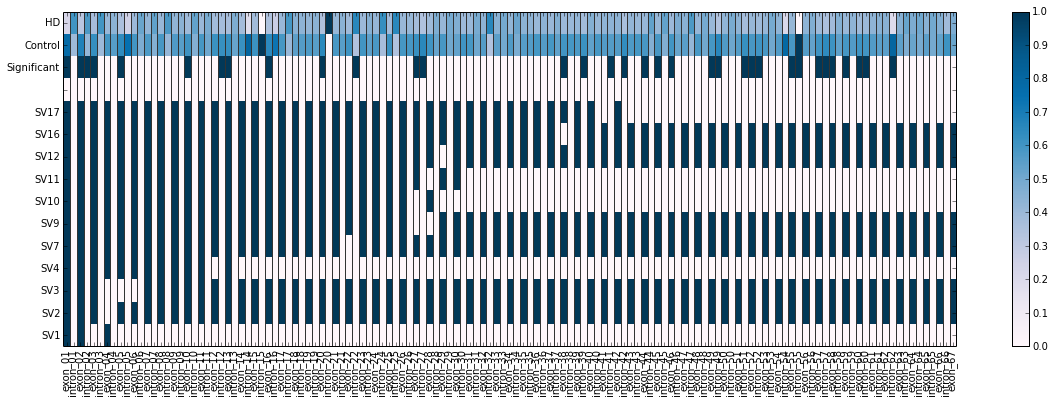

In [137]:
hd_mean = fpbp.ix[hd,].mean(axis=0)

control_mean = fpbp.ix[control,].mean(axis=0)

hd_mean_norm = hd_mean.divide(hd_mean+control_mean).fillna(0)
control_mean_norm = control_mean.divide(hd_mean+control_mean).fillna(0)

from scipy.stats import norm, ttest_ind

# two sample t-test
t,p = ttest_ind(fpbp.ix[hd,],fpbp.ix[control,],equal_var=False)

sig = pd.DataFrame(data=[p<0.05],index=['Significant'],columns=isoforms.columns,dtype='int')
blank = pd.DataFrame(data=[[0]*len(isoforms.columns)],index=[''],columns=isoforms.columns)

means = pd.concat([control_mean_norm,hd_mean_norm],axis=1).T
means_iso = pd.concat([isoforms,blank,sig,means])
means_iso[means_iso==3] = max(hd_mean_norm.max(),control_mean_norm.max())

figure(figsize=(20,6))
pcolor(means_iso,cmap=get_cmap('PuBu'))
axis("tight")
yticks(arange(len(means_iso.index))+0.5,means_iso.index[0:-2].tolist() + ['Control','HD'])
xticks(arange(len(isoforms.columns))+0.5,isoforms.columns,rotation=90)
[vlines(i,0,means_iso.shape[0],'#333333') for i in range(1,means_iso.shape[1])]
colorbar()

# Intronic analysis

,chr,src,type,start,end,name,strand,score,attr,width
exon_00,chr4,HAVANA,exon,3074681,3075088,exon_00,+,.,ID=exon:ENST00000355072.7:1;Parent=ENST0000035...,407
intron_00,chr4,HAVANA,intron,3075088,3086939,intron_00,+,.,ID=intron:ENST00000355072.7:1;Parent=ENST00000...,11851
exon_01,chr4,HAVANA,exon,3086939,3087022,exon_01,+,.,ID=exon:ENST00000355072.7:2;Parent=ENST0000035...,83
intron_01,chr4,HAVANA,intron,3087022,3099274,intron_01,+,.,ID=intron:ENST00000355072.7:2;Parent=ENST00000...,12252
exon_02,chr4,HAVANA,exon,3099274,3099394,exon_02,+,.,ID=exon:ENST00000355072.7:3;Parent=ENST0000035...,120


In [7]:
def coverage_plot(col_set) :
    figure(figsize=(12,3))
    
    xt = arange(len(col_set))
    #xt = htt.start[col_set]
    #xt = cumsum(htt.width[col_set])
    
    hd_up_quant, hd_low_quant = zip(*[(i[1].quantile(0.75),i[1].quantile(0.25)) for i in fpbp.ix[hd,col_set].iteritems()])
    fill_between(xt,hd_up_quant,hd_low_quant,color='b',alpha=0.3)

    control_up_quant, control_low_quant = zip(*[(i[1].quantile(0.75),i[1].quantile(0.25)) for i in fpbp.ix[control,col_set].iteritems()])
    fill_between(xt,control_up_quant,control_low_quant,color='g',alpha=0.3)

    hd_mean = fpbp.ix[hd,col_set].mean(axis=0)
    control_mean = fpbp.ix[control,col_set].mean(axis=0)

    plot(xt,hd_mean)
    plot(xt,control_mean)
    axis("tight")
    xticks(list(xt),col_set,rotation=90)
    grid()

    None

coverage_plot(exon_i)    
title('HD vs Control Exon Coverage')
savefig('exon_coverage.svg')

coverage_plot(intron_i)    
title('HD vs Control Intron Coverage')
savefig('intron_coverage.svg')

hd_mean = fpbp.ix[hd,].mean(axis=0)

control_mean = fpbp.ix[control,].mean(axis=0)

hd_mean_norm = hd_mean.divide(hd_mean+control_mean).fillna(0)
control_mean_norm = control_mean.divide(hd_mean+control_mean).fillna(0)

from scipy.stats import norm, ttest_ind

# two sample t-test
t,p = ttest_ind(fpbp.ix[hd,],fpbp.ix[control,],equal_var=False)

sig = pd.DataFrame(data=[p<0.05],index=['Significant'],columns=isoforms.columns,dtype='int')
#print sig

AssertionError: 10 columns passed, passed data had 9 columns

In [7]:
# I dunno how to make matplotlib find custom fonts, and I don't want to manually set
# font properties on every function call that uses text, so I create function partials
# and call a.<function> when I want to use Arial
from matplotlib.font_manager import findfont, FontProperties, FontManager
import functools
from collections import namedtuple
arial = FontProperties(fname='/usr/share/fonts/truetype/msttcorefonts/comic.ttf')
font_fns = (title,xlabel,ylabel,xticks,yticks,text)
class A(object) : pass
a = A()
[setattr(a,func.func_name,functools.partial(func,fontproperties=arial,fontsize=18)) for func in font_fns]
def custom_legend() :
    l = legend()
    [t.set_font_properties(arial) for t in l.get_texts()]
a.legend = custom_legend